<a href="https://colab.research.google.com/github/raguram/eva/blob/master/S15/ImageSegementation%26DepthEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Check GPU instance

In [0]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-a6887c8d-61e6-ad61-40ce-96a8142b123a)


# Setup

In [0]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load required libraries

In [0]:
import sys

%rm -rf /content/eva
!git clone https://github.com/raguram/eva.git

sys.path.append("/content/eva/cnn-lib/src/cnnlib")
sys.path.append("/content/eva/cnn-lib/src/")
print("Added required libraries to system path")

Cloning into 'eva'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 951 (delta 136), reused 105 (delta 43), pack-reused 691
Receiving objects: 100% (951/951), 36.53 MiB | 32.28 MiB/s, done.
Resolving deltas: 100% (450/450), done.
Added required libraries to system path


In [0]:
!pip install albumentations==0.4.5

     |████████████████████████████████| 122kB 4.8MB/s 
     |████████████████████████████████| 634kB 13.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64378 sha256=208e80ce9d77a17a324fcc642617d44c3dad51136e04968eb0fc71b8b83067f9
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=4cee2efca24b296d57c199197028d8e4e28d0b2ebdac1fe00d5eb4164123440e
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [0]:
from DataUtility import Alb
from albumentations import *
from albumentations.pytorch import ToTensor
from cnnlib import Utility
from torch.nn import functional as F
from cnnlib.DataUtility import Alb
import numpy as np
from cnnlib import DataUtility
import torch.optim as optim
from cnnlib.datasets.DepthDataset import DepthDataset
from cnnlib.models.ResUNet import ResUNet_Dual as ResUNet
from cnnlib.image_seg.ModelBuilder import *
import torch
from torchsummary import summary
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from DataUtility import shape
from cnnlib.DataUtility import Data
from cnnlib.image_seg.ModelBuilder import ModelBuilder
from image_seg.PredictionPersister import ZipPredictionPersister
from image_seg.Loss import Loss_fn
from torch.nn import BCEWithLogitsLoss

### Download and unzip the data set

In [0]:
!rm -rf /content/data
import Utility 
Utility.unzip("/content/drive/My Drive/Colab Notebooks/workspace/data/Assignment15/data.zip", "/content/data")

uncompressed_size 8421.015993


### Model Summary

In [0]:
model = ResUNet(6, 1).to(Utility.getDevice())
summary(model, (6, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             192
       BatchNorm2d-2         [-1, 32, 224, 224]              64
            Conv2d-3         [-1, 32, 224, 224]           1,760
       BatchNorm2d-4         [-1, 32, 224, 224]              64
              ReLU-5         [-1, 32, 224, 224]               0
            Conv2d-6         [-1, 32, 224, 224]           9,248
       BatchNorm2d-7         [-1, 32, 224, 224]              64
              ReLU-8         [-1, 32, 224, 224]               0
        DoubleConv-9         [-1, 32, 224, 224]               0
             ReLU-10         [-1, 32, 224, 224]               0
        MaxPool2d-11         [-1, 32, 112, 112]               0
         ResBlock-12  [[-1, 32, 112, 112], [-1, 32, 224, 224]]               0
           Conv2d-13         [-1, 64, 112, 112]           2,048
      BatchNorm2d-14    

### Transformations

In [0]:
bg_trans = Alb(Compose([
ToTensor(),
]))

fg_bg_trans = Alb(Compose([
ToTensor(),
]))

target_trans = Alb(Compose([ToTensor()]))

### Create data loader

Total number of images in the dataset: 457600
Total number of images in the train dataset: 320320
Shape of a train data batch: torch.Size([32, 3, 224, 224])
Total number of images in the test dataset: 137280
Shape of a test data batch: torch.Size([32, 3, 224, 224])


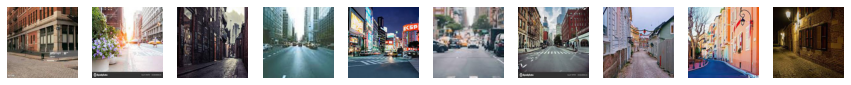

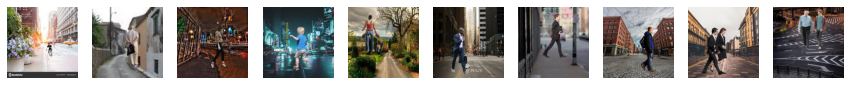

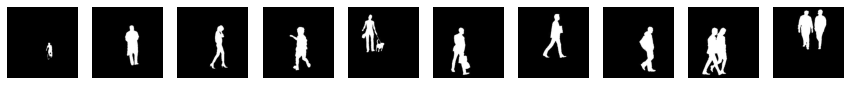

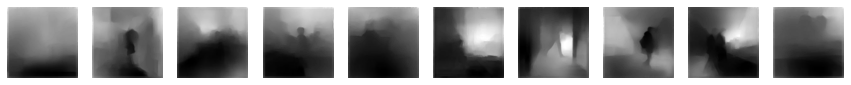

In [0]:
import math 
from DataUtility import Data

def create_loader():

  dataset = DepthDataset("/content/data", bg_transform=bg_trans, fg_bg_transform=fg_bg_trans, 
                         fg_bg_mask_transform=target_trans, fg_bg_depth_transform=target_trans)
  print(f"Total number of images in the dataset: {len(dataset)}") 

  num_train = math.ceil(len(dataset) * 0.70)
  train_dataset = torch.utils.data.Subset(dataset, range(0, num_train))
  test_dataset = torch.utils.data.Subset(dataset, range(num_train, len(dataset)))

  train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=32, num_workers=4)
  test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=32, num_workers=4)

  data = iter(train_loader).next()
  print(f"Total number of images in the train dataset: {len(train_dataset)}") 
  print(f"Shape of a train data batch: {data['fg_bg'].shape}")

  dataset.show_images(10)

  data = iter(test_loader).next()
  print(f"Total number of images in the test dataset: {len(test_dataset)}") 
  print(f"Shape of a test data batch: {data['fg_bg'].shape}")

  return Data(train_loader, test_loader)

data = create_loader()


# Train the model 

Train the network

- Loss: L1 Loss for both mask and depth
- Optimizer: SGD
- LR: 0.5
- Momentum: 0.9
- Epochs: 3


In [0]:
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR

data_folder="/content/data/"

train_output_zip="/content/train-output.zip"
output_zip="/content/output.zip"

output_folder="/content/output/"
model_output_file="/content/drive/My Drive/Colab Notebooks/workspace/data/Assignment15/ISDE-Model.pt"

epochs=3

model = ResUNet(6, 1).to(Utility.getDevice())

loss_fn = Loss_fn(depth_loss=nn.L1Loss(), mask_loss=nn.L1Loss(), alpha=1, beta=1)

LR = 0.5
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = OneCycleLR(optimizer, max_lr=LR, epochs=epochs, steps_per_epoch=3, 
                       pct_start=0.3, anneal_strategy='linear', div_factor=25.0, final_div_factor=10000)

train_persister = ZipPredictionPersister(zip_file_name=train_output_zip, percent=0.01)
test_persister = ZipPredictionPersister(zip_file_name=output_zip, percent=0.01)

### Build model

In [0]:
Utility.cleanup()
builder = ModelBuilder(model=model, data=data, loss_fn=loss_fn,
                       optimizer=optimizer, scheduler=optimizer, train_pred_persister=train_persister, test_pred_persister=test_persister, model_path=model_output_file, checkpoint=1)

result = builder.fit(epochs)

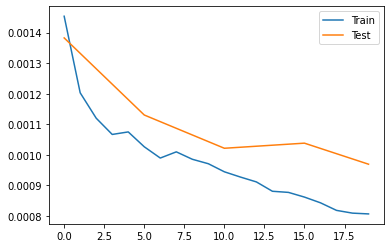

In [0]:
import MetricsUtility
from matplotlib import pyplot as plt

MetricsUtility.plot_x_y(result.train_losses, "Train")
MetricsUtility.plot_x_y(result.test_losses, "Test")
plt.show()

### View prediction result

In [0]:
!rm -rf /content/output/
Utility.unzip(train_output_zip, output_folder)

uncompressed_size 46.130632


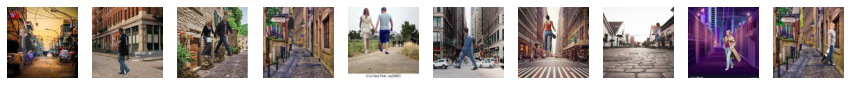

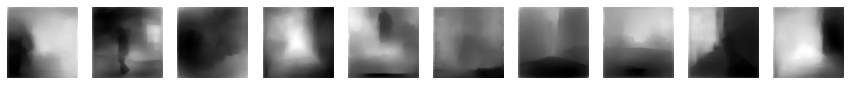

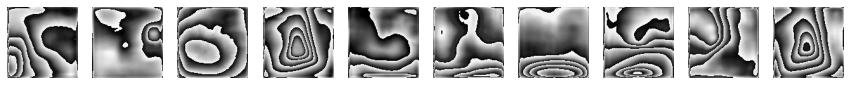

In [0]:
import ImageUtils
from os import listdir
from os.path import join
from PIL import Image

fg_bg_folder = f"{data_folder}fg_bg"

fg_bg_mask_folder = f"{data_folder}fg_bg_mask"
fg_bg_mask_pred = f"{output_folder}/epoch-{epochs-1}/fg_bg_mask"

fg_bg_depth_folder = f"{data_folder}fg_bg_depth"
fg_bg_depth_pred = f"{output_folder}/epoch-{epochs-1}/fg_bg_depth"

file_names = listdir(prediction_folder)[:10]
ImageUtils.show_images([Image.open(join(fg_bg_folder, f)) for f in file_names])
ImageUtils.show_images([Image.open(join(fg_bg_depth_folder, f)) for f in file_names])
ImageUtils.show_images([Image.open(join(prediction_folder, f)) for f in file_names])